In [ ]:
RIGHT NOW NOT WORKING

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

from load_data import load_financial_data, load_sentiment_data
from preprocessing import calculate_financial_change, aggregate_sentiment, aggregate_financials, merge_sentiment_financials
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

In [3]:
#tickers = ['ADA', 'BCH', 'BCN', 'BNB', 'BTC', 'DASH', 'EOS', 'ETC', 'ETH', 'ICX', 'IOT', 'LTC', 'NEO', 'QTUM',
#               'TRON', 'VEN', 'XEM', 'XLM', 'XMR', 'XRP', 'ZEC']

tickers = 'BTC'

In [4]:
df_financials = load_financial_data(filepath = 'data/top20_aggre_price_reduced.csv', start_date = '2017-07-28', end_date = '2018-07-27', tickers = tickers)
df_sentiment = load_sentiment_data(filepath = 'data/BTC_sentiment_aggr_shifted.csv', start_date = '2017-07-28', end_date = '2018-07-27')


In [8]:
# Merge the data
df_merged = merge_sentiment_financials(df_financials, df_sentiment)
df_merged.head(5)
# Remove retweets and favorites (for now)
#df_merged = df_merged.drop(['retweets', 'favorites'], axis = 1)

# Fill the missing values for amount_of_tweets with the ffill method
#df_merged['amount_of_tweets'] = df_merged['amount_of_tweets'].replace(to_replace=0, method = 'ffill')

,retweets,favorites,amount_of_tweets,sentiment,weighted_sentiment,BTC
2017-07-28 00:00:00,20,10,36,-0.638889,-0.767857,2718.7250
2017-07-28 01:00:00,7,18,42,-0.666667,-0.693878,2732.1000
2017-07-28 02:00:00,4,23,35,-0.714286,-0.692308,2720.2025
2017-07-28 03:00:00,14,10,27,-0.666667,-0.731707,2703.2600
2017-07-28 04:00:00,90,72,41,-0.682927,-0.793893,2696.7100


In [33]:
# Prepare for only 1/-1 for sink/fall of financials
df_merged = df_merged.drop(['retweets', 'favorites'], axis = 1)
df_merged['BTC'] = df_merged['BTC']-df_merged['BTC'].shift()
df_merged['BTC'] = np.sign(df_merged['BTC'])
df_merged.dropna(inplace = True)

C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sign
  after removing the cwd from sys.path.


In [10]:
# Get different values for BTC (log, diff, combination)

# Diff
df_merged['BTC_diff'] = df_merged['BTC']-df_merged['BTC'].shift()


# Log
df_merged['BTC_log']= np.log(df_merged['BTC'])

# Diff of log
df_merged['BTC_log_diff'] = df_merged['BTC_log']-df_merged['BTC_log'].shift()

# Drop empty rows which were created through diff
df_merged.dropna(inplace = True)

# Make financial data binary (rise: 1/not rise: 0)
df_merged['BTC_bin'] = np.sign(df_merged['BTC_diff'])
df_merged['BTC_bin'] = df_merged['BTC_bin'].replace(to_replace = -1, value = 0)

#Fill missing values with the ffill method
df_merged['amount_of_tweets'] = df_merged['amount_of_tweets'].replace(to_replace=0, method = 'ffill')
df_merged['sentiment'] = df_merged['sentiment'].replace(to_replace=0, method = 'ffill')
df_merged['weighted_sentiment'] = df_merged['weighted_sentiment'].replace(to_replace=0, method = 'ffill')


In [ ]:
# Augmented Dicky Fuller Test for Stationarity

def test_stationarity(x, name):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation of the ' + name)
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))


In [ ]:
# Test all values for stationarity individually

stationarity_sentiment = test_stationarity(df_merged['sentiment'], 'sentiment')
stationarity_amount = test_stationarity(df_merged['amount_of_tweets'], 'amount of tweets')
stationarity_retweets = test_stationarity(df_merged['retweets'], 'amount of retweets')
stationarity_favorites = test_stationarity(df_merged['favorites'], 'amount of favorites')
stationarity_financials = test_stationarity(df_merged['BTC'], 'value of BTC')



In [ ]:
# Since everything but the financial value is stationary at the the 5% value, we only have to modify the financial value
df_merged['BTC']=np.log(df_merged['BTC'])

# Retest for stationarity
stationarity_financials = test_stationarity(df_merged['BTC'], 'value of BTC')

# Still not stationary. therefore we will have to take tests which use the difference of the values (i.e. ARIMA instead of ARMA)

In [34]:
#checking stationarity: All is good since the eigenvalues are <1
coint_johansen(df_merged,-1,1).eig

array([ 0.35815364,  0.05721948,  0.01048469])

In [26]:
df_relevant = df_merged[['BTC', 'weighted_sentiment']]

In [28]:
# Make train/test split
size = int(len(df_relevant)*0.9)

# Divide into train and test
train_var, test_var = df_relevant[0:size], df_relevant[size:len(df_relevant)]


In [22]:
# Test VARMAX for 4 inputs
history = train_var.values
predictions = list()
originals = list()
error_list = list()

# Creat empty Data Frame for output
evaluation = pd.DataFrame(index=range(0,len(test_var)), columns=[['pred', 'exp', 'error %']])

# Iterate over all days until day x
for t in range(len(test_var)):
    
    # Define and fit model
    model = VARMAX(history, order =(1,1))
    model_fit = model.fit()
    
    # Predict bitcoin value for day x+1
    output = model_fit.forecast(steps=1)
    pred_value = output[0,4]
    
    # Define the other factors for the output
    original_value = test_var.iloc[t, 4]  
    error = ((abs(pred_value - original_value)) / original_value) * 100

    # Print output for day x+1
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    # Lists for plots
    error_list.append(error)
    predictions.append(float(pred_value))
    originals.append(float(original_value))

    # Add the values for day x+1 to the output dataframe
    evaluation.iloc[t][0] = pred_value
    evaluation.iloc[t][1] = original_value
    evaluation.iloc[t][2] = error
    
    # fill newest row in history to adjust data for next iteration
    history = np.concatenate((history,test_var.values[t,:].reshape(1,5)))
    
    #delete output to make sure that it doesnt stick for other evaluations
    del output

    

C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


IndexError: index 4 is out of bounds for axis 1 with size 2

In [29]:
# Test VARMAX for 2 input variables 
history = train_var.values
predictions = list()
originals = list()
error_list = list()

# Creat empty Data Frame for output
evaluation = pd.DataFrame(index=range(0,len(test_var)), columns=[['pred', 'exp', 'error %']])

# Iterate over all days until day x
for t in range(len(test_var)):
    
    # Define and fit model
    model = VARMAX(history, order =(1,1))
    model_fit = model.fit()
    
    # Predict bitcoin value for day x+1
    output = model_fit.forecast(steps=1)
    pred_value = output[0,1]
    
    # Define the other factors for the output
    original_value = test_var.iloc[t, 1]  
    error = ((abs(pred_value - original_value)) / original_value) * 100

    # Print output for day x+1
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    # Lists for plots
    error_list.append(error)
    predictions.append(float(pred_value))
    originals.append(float(original_value))

    # Add the values for day x+1 to the output dataframe
    evaluation.iloc[t][0] = pred_value
    evaluation.iloc[t][1] = original_value
    evaluation.iloc[t][2] = error
    
    # fill newest row in history to adjust data for next iteration
    history = np.concatenate((history,test_var.values[t,:].reshape(1,2)))
    
    #delete output to make sure that it doesnt stick for other evaluations
    del output

    

C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


predicted = -0.536491,   expected = -0.713376,   error = -24.795445  %


C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


predicted = -0.573298,   expected = 0.019704,   error = 3009.486701  %


C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


predicted = -0.497013,   expected = -0.582011,   error = -14.604100  %


C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


predicted = -0.559529,   expected = -0.748634,   error = -25.260035  %


C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


predicted = -0.577448,   expected = -0.492795,   error = -17.178073  %


C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\envs\sentiment_env\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


predicted = -0.550766,   expected = -0.657534,   error = -16.237745  %


KeyboardInterrupt: 


 Mean Error in Predicting Test Case Articles : 0.347528  %


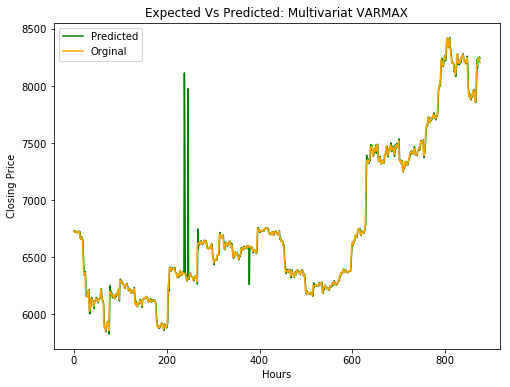

In [9]:
# Calculate overall mean error after all iterations
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')

# Plot the Expected Vs Predicted Forecasting
plot.figure(figsize=(8, 6))
test_day = [t for t in range(len(test_var))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted: Multivariat VARMAX')
plot.xlabel('Hours')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

In [42]:
np.mean(evaluation['error %'])

error %    0.853881
dtype: float64

In [35]:
evaluation_cleaned = evaluation.drop([238, 239, 246, 266, 378])